In [1]:
# some pre-requirements to do slight change into my modules
import sys
for i in range(len(sys.path)):
    sys.path.remove(sys.path[0])
print(sys.path)

[]


In [2]:
path_list = ['', '/scratch/hz1922/myjupyter/.env/lib/python36.zip', '/scratch/hz1922/myjupyter/.env/lib/python3.6', '/scratch/hz1922/myjupyter/.env/lib/python3.6/lib-dynload', '/share/apps/python3/3.6.3/intel/lib/python3.6', '/scratch/hz1922/myjupyter/.env/lib/python3.6/site-packages', '/scratch/hz1922/myjupyter/.env/lib/python3.6/site-packages/IPython/extensions']
for i in range(len(path_list)):
    sys.path.append(path_list[i])
print(sys.path)

['', '/scratch/hz1922/myjupyter/.env/lib/python36.zip', '/scratch/hz1922/myjupyter/.env/lib/python3.6', '/scratch/hz1922/myjupyter/.env/lib/python3.6/lib-dynload', '/share/apps/python3/3.6.3/intel/lib/python3.6', '/scratch/hz1922/myjupyter/.env/lib/python3.6/site-packages', '/scratch/hz1922/myjupyter/.env/lib/python3.6/site-packages/IPython/extensions']


In [3]:
print(sys.path)

['', '/scratch/hz1922/myjupyter/.env/lib/python36.zip', '/scratch/hz1922/myjupyter/.env/lib/python3.6', '/scratch/hz1922/myjupyter/.env/lib/python3.6/lib-dynload', '/share/apps/python3/3.6.3/intel/lib/python3.6', '/scratch/hz1922/myjupyter/.env/lib/python3.6/site-packages', '/scratch/hz1922/myjupyter/.env/lib/python3.6/site-packages/IPython/extensions']


## Convolutional & Conditional VAEs

In this problem you will implement: 
1. a **convolutional** variational autoencoder
2. a (convolutional) **conditional** variational autoencoder,

trained on the MNIST dataset. 
The convolutional parameterization will help you achieve better marginal log likelihood. Using the conditional VAE, you'll be able to generate novel images of a specified class.


In [4]:
%pylab inline
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.distributions import MultivariateNormal
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


In [5]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True, 
          transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)




---
# 1. Convolutional variational autoencoder (20 points)


Your task is to implement a VAE for MNIST, using a **convolutional network** in the encoder, and a **convolutional network** in the decoder.

- **Overall Goal:** achieve better estimated marginal likelihood than in the lab
  - Keep `z=20` as in the lab 


**Encoder**: you are free to design the convolutional network how you want. 
  - We used three `Conv2d + ReLU` layers, with an output size of `B x 64 x 7 x 7`.
  - Hint: Flatten the output of your convolutional network before mapping it to the encoder outputs, e.g. $\mu = \texttt{linear(flatten(conv(x)))}$


**Decoder**: you are free to design the convolutional network how you want. 
  - We used three `ConvTranspose2d + ReLU` layers, with an input size of `B x 64 x 7 x 7`.
  - Hint: Map the $\mathbf{z}$ input to the convolutional input size.
    - $\hat{x}=\texttt{deconv(reshape(linear(z)))}$

In [232]:
class Encoder(nn.Module):
    def __init__(self, zdim):
        super().__init__()
        # TODO
        nf = 16
        # convolution
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, nf, 3, 2, 1),
                        nn.BatchNorm2d(nf),
                        nn.ReLU(True)
        )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(nf, nf*2, 3, 2, 1),
                        nn.BatchNorm2d(nf*2),
                        nn.ReLU(True)
        )
        self.conv3 = nn.Sequential(
                        nn.Conv2d(nf*2, nf*4, 3, 1, 1),
                        nn.BatchNorm2d(nf*4),
                        nn.ReLU(True)
        )

        
        self.mu = nn.Linear(3136, zdim)
        self.logvar = nn.Linear(3136, zdim)
        self.zdim = zdim

    def forward(self, x):
        # TODO
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x3 = torch.flatten(x3, 1)
        mu = self.mu(x3) 
        logvar = self.logvar(x3)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, zdim):
        super().__init__()
        nf = 16

        self.deconv = nn.Linear(zdim, nf*4*49)
        
        self.trans_conv1 = nn.Sequential(
                            nn.ConvTranspose2d(nf*4, nf*2, 3, 1, 1),
                            nn.BatchNorm2d(nf*2),
                            nn.ReLU(True)
        )

        self.trans_conv2 = nn.Sequential(
                            nn.ConvTranspose2d(nf*2, nf*1, 4, 2, 1),
                            nn.BatchNorm2d(nf*1),
                            nn.ReLU(True)
        )
        self.trans_conv3 = nn.Sequential(
                            nn.ConvTranspose2d(nf, 1, 4, 2, 1),
                            nn.Sigmoid()
        )
    

    def forward(self, x):
        x = self.deconv(x)
        x = x.view(x.shape[0], 64, 7, 7)
        x1 = self.trans_conv1(x)
        x2 = self.trans_conv2(x1)
        x3 = self.trans_conv3(x2)
        out = x3
        return out


class VAE(nn.Module):
    def __init__(self, zdim):
        super().__init__()
        self.encoder = Encoder(zdim)
        self.decoder = Decoder(zdim)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            z = mu + std*eps
        else:
            z = mu
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        xhat = self.decoder(z)
        return xhat, mu, logvar

**Loss**: does anything change from the lab?

In [233]:
# hint: see lab
def loss_function(xhat, x, mu, logvar, kl_weight=1.0):
    BCE = nn.functional.binary_cross_entropy(
      xhat.view(xhat.size(0),-1), x.view(x.size(0), -1), reduction='none').sum(1).mean()
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1).mean()
    loss = BCE + kl_weight*KLD
    return loss, BCE.item(), KLD.item()

**Train on MNIST**: does anything change from the lab?

**Your task:** Implement training logic, and *produce a plot of training loss and a plot of validation loss* (x-axis: epoch, y-axis: loss). Each plot should contain three lines: total loss, BCE, and KL-divergence.

In [275]:
device = torch.device("cuda:0")
zdim = 20        # use this
kl_weight = 1.0  # use this

model = VAE(zdim=20).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
)

In [ ]:
def train(epoch):
    model.train()
    train_loss, bce, kld = 0, 0, 0
    for batch_idx, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        x = x.to(device)

        optimizer.zero_grad()
        xhat, mu, logvar = model(x)
        loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        bce += bce_
        kld += kld_

    bce /= len(train_loader.dataset)
    kld /= len(train_loader.dataset)
    train_loss /= len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        epoch, 
        train_loss, 
        bce,
        kld
    ))
    return train_loss, bce, kld


def validate(epoch):
    cache = dict(mus=[], logvars=[], ys=[])
    mus, logvars, ys = [], [], []
    model.eval()
    test_loss, bce, kld = 0, 0, 0
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            
            x = x.to(device)
            xhat, mu, logvar = model(x)
            loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)

            test_loss += loss.item()
            bce += bce_
            kld += kld_
            cache['mus'].append(mu.detach())
            cache['logvars'].append(logvar.detach())
            cache['ys'].append(y.detach())

    test_loss /= len(test_loader.dataset)
    bce /= len(test_loader.dataset)
    kld /= len(test_loader.dataset)
    print('====> Valid set loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        test_loss,
        bce,
        kld
    ))
    return cache, test_loss, bce, kld

# train, validate ..
best_loss = 1e5
cache = dict(mus=[], logvars=[], ys=[], valid_loss=[], valid_bce=[], valid_kld=[], train_loss=[], train_bce=[], train_kld=[])
wait = 10
cnt = 0
for epoch in range(1,300):
    cache_, valid_loss, valid_bce, valid_kld = validate(epoch)  
    train_loss, train_bce, train_kld = train(epoch)


    cache['valid_loss'].append(valid_loss)
    cache['valid_bce'].append(valid_bce)
    cache['valid_kld'].append(valid_kld)
    cache['train_loss'].append(train_loss)
    cache['train_bce'].append(train_bce)
    cache['train_kld'].append(train_kld)
    
    if cnt>wait:
        break

    if valid_loss < best_loss:
        cnt = 0
        torch.save({
            'state_dict': model.state_dict(),
            'valid_loss': cache['valid_loss'],
            'validbcse': cache['valid_bce'],
            'valid_kld': cache['valid_kld'],
            'train_loss': cache['train_loss'],
            'train_bce': cache['train_bce'],
            'train_kld': cache['train_kld'],
        }, open('model.pt', 'wb'))
        best_loss = valid_loss
    else:
        cnt+=1
        print("waiting time: ",cnt)

### Evaluation
- **We provide the code below for sampling, interpolation, and marginal likelihood estimation**
- Sampling and interpolation: achieve similar to the lab (this is subjective, so the purpose is to check if something is *way off*)
- Marginal likelihood: achieve better than the lab



*Please ensure that `model` contains the model state that you will use for evaluation before running these.*

#### Sampling

*no code modification needed*

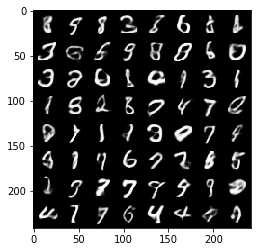

In [282]:
from torchvision.utils import make_grid

N = 64
model.eval()

# Sample z~p(z)
z = torch.randn((N, model.encoder.zdim)).to(device)

# Decode
sample = model.decoder(z)

# Visualize
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

imgs = sample
grid = make_grid(imgs).detach().cpu()
show(grid)

#### Interpolation

*no code modification needed*

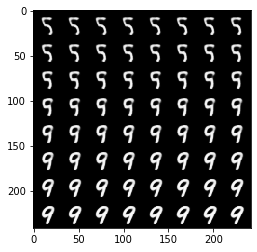

In [280]:
# Visualize
from torchvision.utils import make_grid

model.eval()

x, y = next(train_loader.__iter__())
xhat, mu, logvar = model(x.cuda())
si, ei = np.random.choice(batch_size, size=2, replace=False)
start = mu[si]
end = mu[ei]

N = 64

zs = torch.zeros(N, model.encoder.zdim).to(device)
for i in range(N):
    zs[i] = i / (N) * start.data + (1 - i / (N) ) * end.data
xhat = model.decoder(zs)

imgs = xhat.unsqueeze(0).unsqueeze(0).view(N, 1, 28, 28)
grid = make_grid(imgs).detach().cpu()
show(grid)

#### Marginal likelihood

*no code modification needed*

In [242]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

eval_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=1, shuffle=True)

N_samples = 128

model.eval()
results = []
with torch.no_grad():
    for i, (x, y) in tqdm(enumerate(eval_loader), total=len(eval_loader)):
        x, y = next(eval_loader.__iter__())
        x = x.to(device).expand(N_samples, 1, 28, 28)
        # Obtain mu, logvar and sample z
        _, mu, logvar = model(x)
        z = mu + logvar.mul(0.5).exp()*torch.randn_like(mu)

        # Obtain xhat given the sampled z
        xhat = model.decoder(z)

        # Make a standard normal for p(z) and a normal for q(z|x)
        norm = MultivariateNormal(
            torch.zeros_like(mu[0]), 
            covariance_matrix=torch.diag(torch.ones_like(logvar[0]))
        )
        mvn = MultivariateNormal(
            mu[0], 
            covariance_matrix=torch.diag(logvar.exp()[0])
        )

        # Measure the (log) probabilities needed for the formula above
        log_pz = norm.log_prob(z)
        log_qzx = mvn.log_prob(z)
        x = x.view(xhat.size())
        log_pxz = -nn.functional.binary_cross_entropy(
            xhat, x, reduction='none'
        ).view(N_samples, -1).sum(1)

        # Compute the lowerbound (in log space)
        argsum = log_pxz + log_pz - log_qzx
        logpx = -np.log(N_samples) + torch.logsumexp(argsum, 0)
        results.append(logpx.item())

print(np.mean(results))

100%|██████████| 10000/10000 [10:22<00:00, 16.06it/s]

-92.84845636405944


Since the log probability is larger than the one showed in the lab, we gain better marginal likelihood.

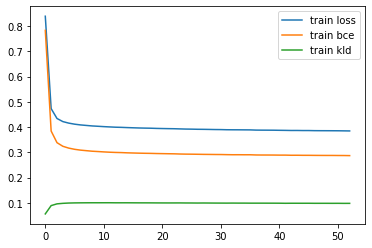

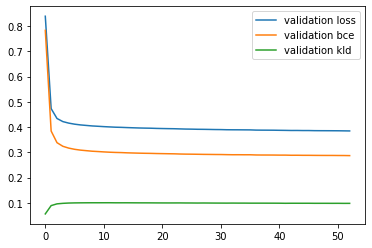

In [281]:
import matplotlib.pyplot as plt
import numpy as np

checkpoint = torch.load('model.pt')
valid_loss = checkpoint['valid_loss']
valid_bce = checkpoint['validbcse']
valid_kld = checkpoint['valid_kld']
train_loss = checkpoint['train_loss']
train_bce = checkpoint['train_bce']
train_kld = checkpoint['train_kld']

x = np.arange(0,len(train_loss))

plt.figure()
plt.plot(x,train_loss,label='train loss')
plt.plot(x,train_bce,label='train bce')
plt.plot(x,train_kld,label='train kld')
plt.legend()

plt.figure()
x_valid = np.arange(0,len(valid_loss))
plt.plot(x,train_loss,label='validation loss')
plt.plot(x,train_bce,label='validation bce')
plt.plot(x,train_kld,label='validation kld')
plt.legend()



---

# 2. Conditional variational autoencoder (20 points)

### A. Model

The conditional VAE involves:
- $q_{\phi}(\mathbf{z}|\mathbf{x},c)$: "encoder"
- $p_{\theta}(\mathbf{x}|\mathbf{z},c)$: "decoder"
- $p(\mathbf{z})$: prior

In our case, $c\in \{0,...,9\}$ is a discrete variable (class label).

**Your task:** Implement a `CVAE` that has an `encoder`, `decoder`, and `reparameterization`.

*Hints*: 
  1. Represent $c$ using a `nn.Embedding` layer, and concatenate it to the representation of $\mathbf{x}$.
    - e.g. $\mu = \texttt{linear([conv(x); emb(c)])}$
  2. Represent `decoder` inputs $\mathbf{z},c$ similarly, as $[\mathbf{z};\text{emb}(c)]$.
    - $\hat{x}=\texttt{deconv(linear([z; emb(c)]))}$

Otherwise, everything else is the same as VAE (plus passing $c$ as an argument in the right places). You can use the same convolutional layers as above.

In [146]:
def idx2onehot(idx, n):

    assert torch.max(idx).item() < n

    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)
    return onehot.cuda()


class Encoder(nn.Module):
    def __init__(self, zdim, nclasses):
        # TODO
        super().__init__()

        self.embed_class = nn.Linear(nclasses, 28 * 28)
        self.embed_data = nn.Conv2d(1, 1, kernel_size=1)
        
        nf = 16
        # convolution
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, nf, 3, 2, 1),
                        nn.BatchNorm2d(nf),
                        nn.ReLU(True)
        )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(nf, nf*2, 3, 2, 1),
                        nn.BatchNorm2d(nf*2),
                        nn.ReLU(True)
        )
        self.conv3 = nn.Sequential(
                        nn.Conv2d(nf*2, nf*4, 3, 1, 1),
                        nn.BatchNorm2d(nf*4),
                        nn.ReLU(True)
        )

        self.mu = nn.Linear(6272, zdim)
        self.logvar = nn.Linear(6272, zdim)
        self.zdim = zdim
        self.nclasses = nclasses
        
        

    def forward(self, x, c):
        # TODO
        
        c = idx2onehot(c, n=self.nclasses)
        c = self.embed_class(c)
        c = c.view(-1, 28, 28).unsqueeze(1)
        x = self.embed_data(x)
        x = torch.cat((x, c), dim=-1)
      
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x3 = torch.flatten(x3, 1)
        mu = self.mu(x3) 
        logvar = self.logvar(x3)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, zdim, nclasses):
        super().__init__()
        # TODO
        nf = 16
        self.deconv = nn.Linear(zdim+nclasses, nf*4*49)
        
        self.trans_conv1 = nn.Sequential(
                            nn.ConvTranspose2d(nf*4, nf*2, 3, 1, 1),
                            nn.BatchNorm2d(nf*2),
                            nn.ReLU(True)
        )

        self.trans_conv2 = nn.Sequential(
                            nn.ConvTranspose2d(nf*2, nf*1, 4, 2, 1),
                            nn.BatchNorm2d(nf*1),
                            nn.ReLU(True)
        )
        self.trans_conv3 = nn.Sequential(
                            nn.ConvTranspose2d(nf, 1, 4, 2, 1),
                            nn.Sigmoid()
        )
        self.nclasses = nclasses

    def forward(self, z, c):
        # TODO
        c = idx2onehot(c, n=self.nclasses)
        z = torch.cat([z, c], dim = 1)
        

        
        x = z
        x = self.deconv(x)
        x = x.view(x.shape[0], 64, 7, 7)
        x1 = self.trans_conv1(x)
        x2 = self.trans_conv2(x1)
        x3 = self.trans_conv3(x2)
        out = x3
        return out


class CVAE(nn.Module):
    def __init__(self, zdim, nclasses):
        super().__init__()
        # TODO
        self.zdim = zdim
        self.nclasses = nclasses
        
        self.encoder = Encoder(zdim, nclasses)
        self.decoder = Decoder(zdim, nclasses)

        

    def reparameterize(self, mu, logvar):
        # TODO
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            z = mu + std*eps
        else:
            z = mu
        return z

    def forward(self, x, c):
        # TODO
        
        mu, logvar = self.encoder(x, c)
        z = self.reparameterize(mu, logvar)
        xhat = self.decoder(z, c)
        return xhat, mu, logvar
    
        

**Loss:** same as VAE.

In [147]:
# hint: see lab
def loss_function(xhat, x, mu, logvar, kl_weight=1.0):
    BCE = nn.functional.binary_cross_entropy(
      xhat.view(xhat.size(0),-1), x.view(x.size(0), -1), reduction='none').sum(1).mean()
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1).mean()
    loss = BCE + kl_weight*KLD
    return loss, BCE.item(), KLD.item()

### C. Training

Train your conditional VAE model using your loss function on MNIST.

**Your task:** Implement training logic, and *produce a plot of training loss and a plot of validation loss* (x-axis: epoch, y-axis: loss). Each plot should contain three lines: total loss, BCE, and KL-divergence.


In [152]:
device = torch.device("cuda:0")
zdim = 20        # use this
kl_weight = 1.0  # use this

model = CVAE(zdim=20, nclasses=10).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
)

In [ ]:
def train(epoch):
    model.train()
    train_loss, bce, kld = 0, 0, 0
    for batch_idx, (x, c) in tqdm(enumerate(train_loader), total=len(train_loader)):
        x = x.to(device)

        optimizer.zero_grad()
        xhat, mu, logvar = model(x,c)
        loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        bce += bce_
        kld += kld_

    bce /= len(train_loader.dataset)
    kld /= len(train_loader.dataset)
    train_loss /= len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        epoch, 
        train_loss, 
        bce,
        kld
    ))
    return train_loss, bce, kld


def validate(epoch):
    cache = dict(mus=[], logvars=[], ys=[])
    mus, logvars, ys = [], [], []
    model.eval()
    test_loss, bce, kld = 0, 0, 0
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            
            x = x.to(device)
            c = y
            xhat, mu, logvar = model(x,c)
            loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)

            test_loss += loss.item()
            bce += bce_
            kld += kld_
            cache['mus'].append(mu.detach())
            cache['logvars'].append(logvar.detach())
            cache['ys'].append(y.detach())

    test_loss /= len(test_loader.dataset)
    bce /= len(test_loader.dataset)
    kld /= len(test_loader.dataset)
    print('====> Valid set loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        test_loss,
        bce,
        kld
    ))
    return cache, test_loss, bce, kld

# train, validate ..
best_loss = 1e5
cache = dict(mus=[], logvars=[], ys=[], valid_loss=[], valid_bce=[], valid_kld=[], train_loss=[], train_bce=[], train_kld=[])
wait = 10
cnt = 0
for epoch in range(1,100):
    cache_, valid_loss, valid_bce, valid_kld = validate(epoch)  
    train_loss, train_bce, train_kld = train(epoch)


    cache['valid_loss'].append(valid_loss)
    cache['valid_bce'].append(valid_bce)
    cache['valid_kld'].append(valid_kld)
    cache['train_loss'].append(train_loss)
    cache['train_bce'].append(train_bce)
    cache['train_kld'].append(train_kld)
    
    if cnt>wait:
        break

    if valid_loss < best_loss:
        cnt = 0
        torch.save({
            'state_dict': model.state_dict(),
            'valid_loss': cache['valid_loss'],
            'validbcse': cache['valid_bce'],
            'valid_kld': cache['valid_kld'],
            'train_loss': cache['train_loss'],
            'train_bce': cache['train_bce'],
            'train_kld': cache['train_kld'],
        }, open('model_cvae.pt', 'wb'))
        best_loss = valid_loss
    else:
        cnt+=1
        print("waiting time: ",cnt)

### D. Conditional generation

**Your task**: complete the code below to produce a grid of samples with 10 rows, where the $i$'th row has samples of class $i$.

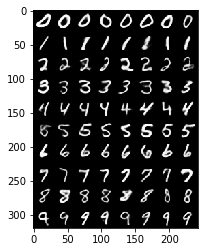

In [154]:
from torchvision.utils import make_grid
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    

N = 8
model.eval()
grids = []
for y_ in range(10):
    # TODO (the ... does not imply it is a single line)
    # sample = ...
    z = torch.randn((N, model.encoder.zdim)).to(device)
    c = torch.zeros(N, dtype=torch.int64).cuda()
    for i in range(0, 8):
        c[i]=int(y_)
    
    sample = model.decoder(z, c)
    grid = make_grid(sample).detach().cpu()
    grids.append(grid)

grid = torch.cat(grids, 1)
show(grid);